<a href="https://colab.research.google.com/github/ramnathv/full-stack-ml-metaflow-corise-week-2/blob/main/notebooks/week-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 2: Designing Machine Learning Workflows

## Set up Environment

In [1]:
#@title Install Packages
!echo "📦 Installing packages"
!pip install metaflow pylint > /dev/null
!echo "🍴 Setting USERNAME to metaflow_user"
import os
os.environ["USERNAME"] = "metaflow_user"

📦 Installing packages
🍴 Setting USERNAME to metaflow_user


In [47]:
#@title Import Modules
import polars as pl
import pandas as pd
import plotly.express as px
import nltk
import string
from rich import print

# Update plotly defaults
px.defaults.width = 800
px.defaults.height = 450

%config InlineBackend.figure_format='retina'

___
- Thinking from Engineer POV: what does it mean to build this application from an engineering context?
- How to build ML workflows with Metaflow
- Versioning, model reporting, and notebooks
- Iterative approach to building ML workflows
___

## Engineer POV

## Building ML workflows with Metaflow

An improved version of the flow:
- Leave the baseline in a separate branch
- Create a step that performs basic featurization
- Train/test split
- Train a model
- Produce predictions


## The Unreasonable Effective of Branching Flows

Often, you'll want to train several independent models and then choose the best one. As they're indepedendent, you can train them in parallel. For this, you can use the concept of branching, which is exemplified in this figure:


<img src="https://github.com/ramnathv/full-stack-ml-metaflow-corise-week-2/blob/main/img/flow_ex_0.png?raw=1" alt="DAG" style="width: 400px;"/>

Let's now do this in Metaflow by writing a flow that has random forests, decision trees, and extra trees classifiers, trains them all and chooses the best one.

The following flow so that it has random forests, decision trees, and extra trees classifiers, trains them all and chooses the best one.

In [3]:
%%writefile tree_branch_flow.py

from metaflow import FlowSpec, step, card

class Branch_Flow(FlowSpec):
    """
    train multiple tree based methods
    """
    @card
    @step
    def start(self):
        """
        Load the data
        """
        #Import scikit-learn dataset library
        from sklearn import datasets

        #Load dataset
        self.iris = datasets.load_iris()
        self.X = self.iris['data']
        self.y = self.iris['target']
        self.next(self.rf_model, self.xt_model, self.dt_model)


    @step
    def rf_model(self):
        """
        build random forest model
        """
        from sklearn.ensemble import RandomForestClassifier
        from sklearn.model_selection import cross_val_score

        self.clf = RandomForestClassifier(n_estimators=10, max_depth=None,
            min_samples_split=2, random_state=0)
        self.scores = cross_val_score(self.clf, self.X, self.y, cv=5)
        self.next(self.choose_model)

    @step
    def xt_model(self):
        """
        build extra trees classifier
        """
        from sklearn.ensemble import ExtraTreesClassifier
        from sklearn.model_selection import cross_val_score


        self.clf = ExtraTreesClassifier(n_estimators=10, max_depth=None,
            min_samples_split=2, random_state=0)

        self.scores = cross_val_score(self.clf, self.X, self.y, cv=5)
        self.next(self.choose_model)

    @step
    def dt_model(self):
        """
        build decision tree classifier
        """
        from sklearn.tree import DecisionTreeClassifier
        from sklearn.model_selection import cross_val_score

        self.clf = DecisionTreeClassifier(max_depth=None, min_samples_split=2,
            random_state=0)

        self.scores = cross_val_score(self.clf, self.X, self.y, cv=5)

        self.next(self.choose_model)

    @step
    def choose_model(self, inputs):
        """
        find 'best' model
        """
        import numpy as np

        def score(inp):
            return inp.clf,\
                   np.mean(inp.scores)


        self.results = sorted(map(score, inputs), key=lambda x: -x[1])
        self.model = self.results[0][0]
        self.next(self.end)

    @step
    def end(self):
        """
        End of flow!
        """
        print('Scores:')
        print('\n'.join('%s %f' % res for res in self.results))
        print('Best model:')
        print(self.model)


if __name__ == "__main__":
    Branch_Flow()

Writing tree_branch_flow.py


Execute the above from the command line with

```bash
python flows/local/tree_branch_flow.py run
```

In [4]:
! python tree_branch_flow.py run

Metaflow 2.10.6 executing Branch_Flow for user:metaflow_user
Creating local datastore in current directory (/content/.metaflow)
Validating your flow...
    The graph looks good!
Running pylint...
    Pylint is happy!
2023-11-03 22:57:30.871 Workflow starting (run-id 1699052250863498):
2023-11-03 22:57:30.874 [1699052250863498/start/1 (pid 1307)] Task is starting.
2023-11-03 22:57:33.265 [1699052250863498/start/1 (pid 1307)] Task finished successfully.
2023-11-03 22:57:33.268 [1699052250863498/rf_model/2 (pid 1329)] Task is starting.
2023-11-03 22:57:33.271 [1699052250863498/xt_model/3 (pid 1330)] Task is starting.
2023-11-03 22:57:33.280 [1699052250863498/dt_model/4 (pid 1331)] Task is starting.
2023-11-03 22:57:35.221 [1699052250863498/rf_model/2 (pid 1329)] Task finished successfully.
2023-11-03 22:57:35.253 [1699052250863498/dt_model/4 (pid 1331)] Task finished successfully.
2023-11-03 22:57:35.271 [1699052250863498/xt_model/3 (pid 1330)] Task finished successfully.
2023-11-03 22:57

We can also view the Metaflow card:

```
python flows/local/tree_branch_flow.py card view start
```

In [ ]:
! python tree_branch_flow.py card view start

Metaflow 2.7.21.4 executing Branch_Flow for user:sandbox
Resolving card: Branch_Flow/32/start/152


In [48]:
from metaflow.cards import get_cards
from metaflow import Flow, namespace
from rich.pretty import pprint
flow = Flow('Branch_Flow')
run = flow.latest_run
tasks = list(steps[5].tasks())
get_cards(tasks[0])

## Branching flows with the Titanic

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

df = pd.read_csv('https://raw.githubusercontent.com/ramnathv/full-stack-ml-metaflow-corise-week-2/main/data/titanic.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


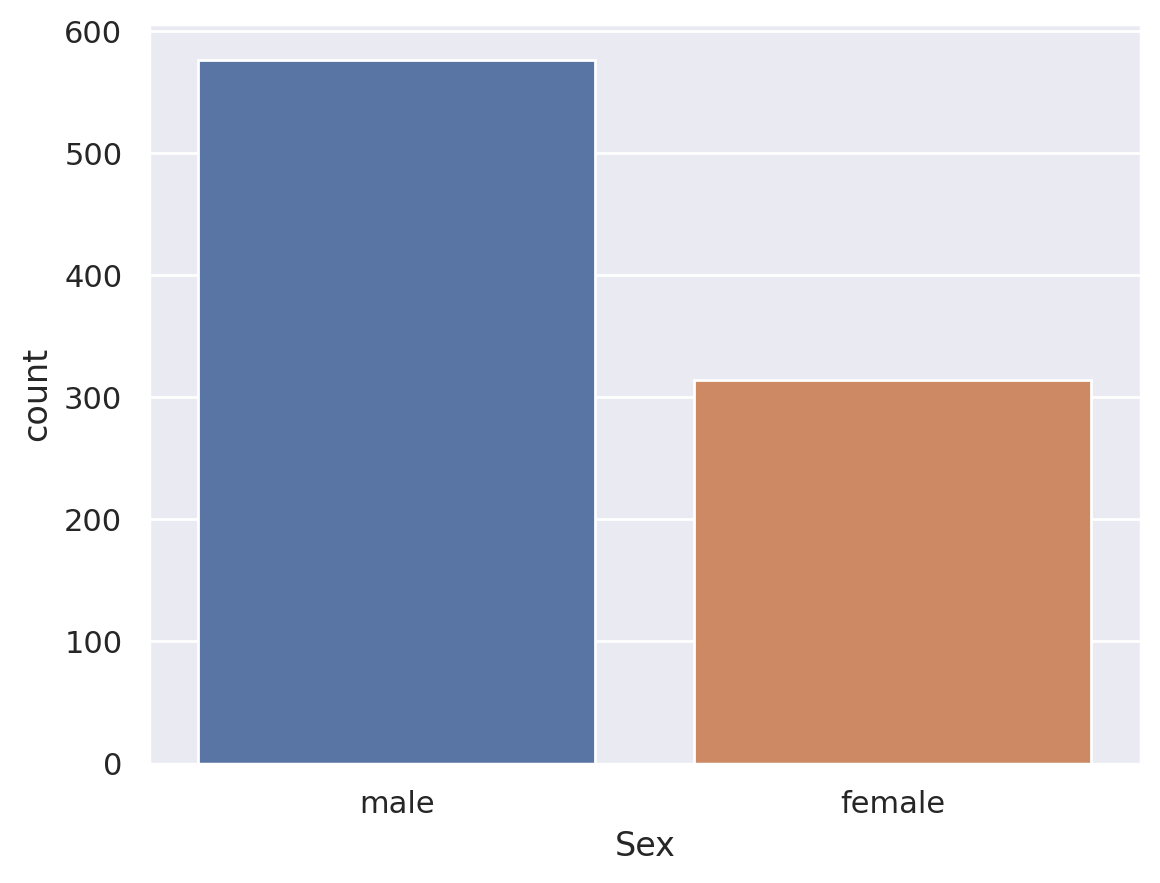

In [51]:
sns.countplot(x='Sex', data=df);

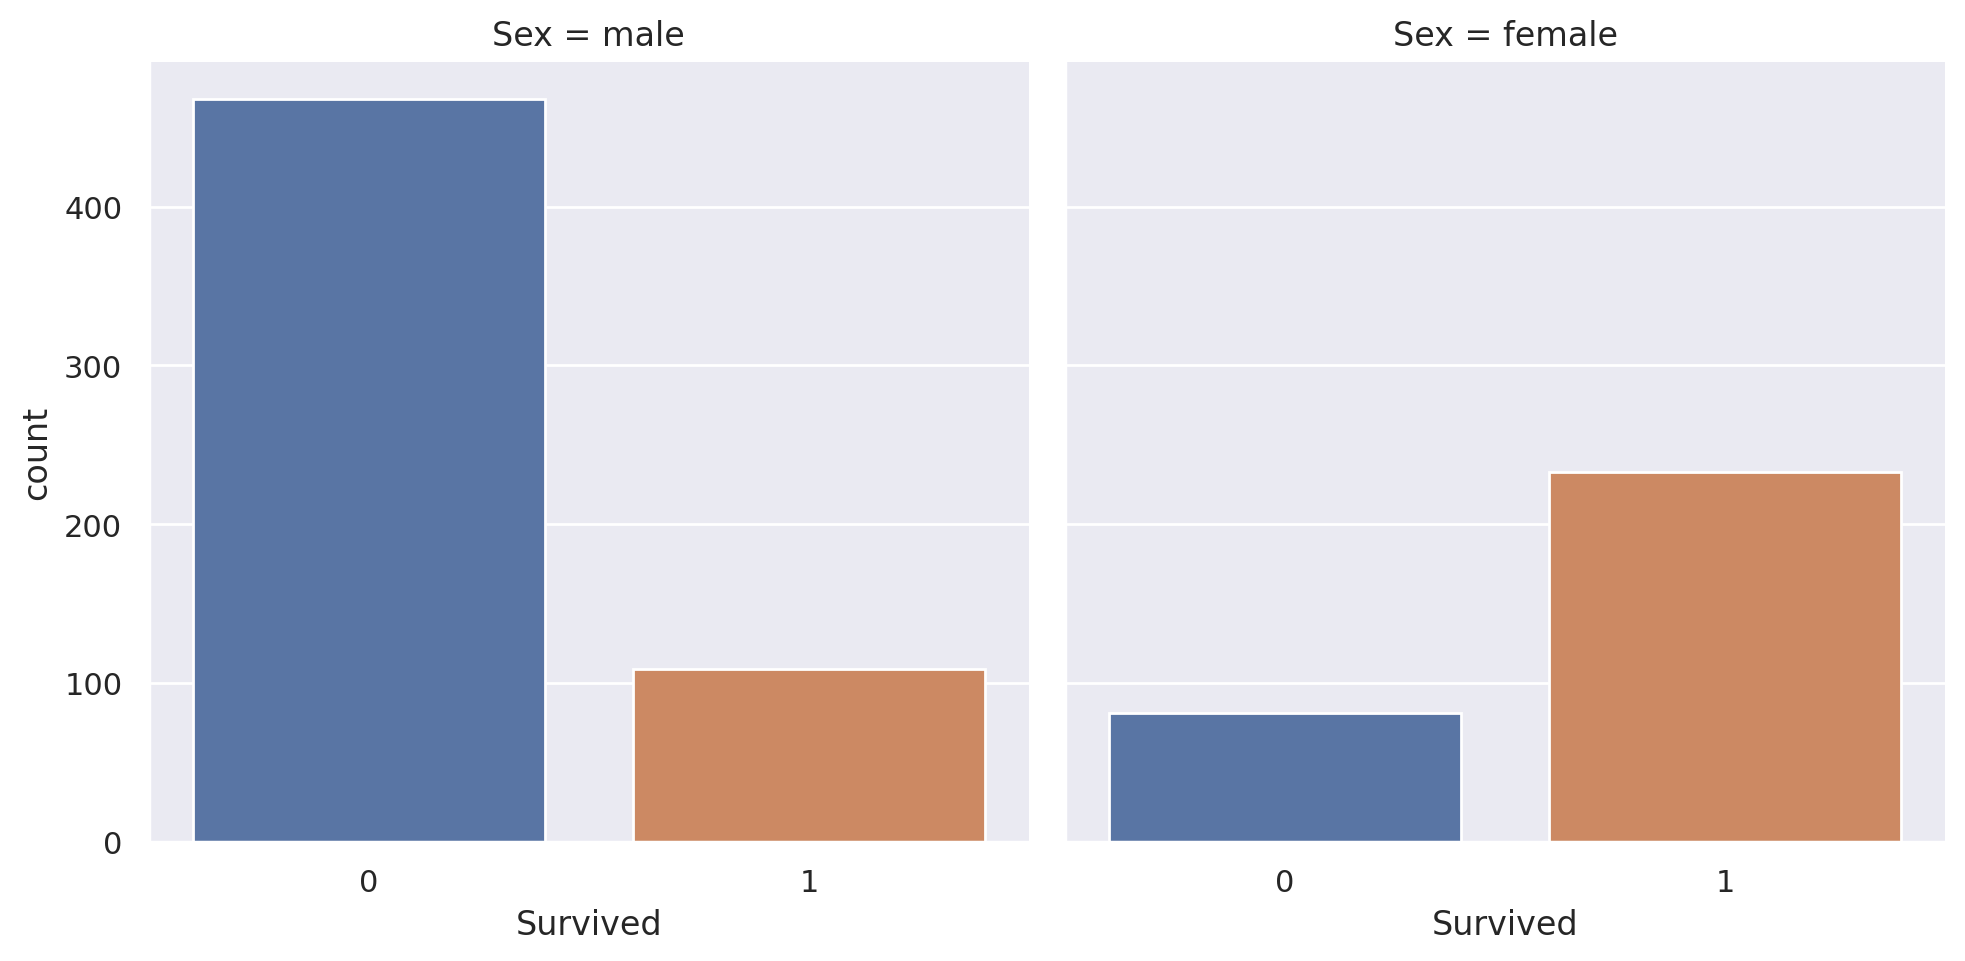

In [50]:
sns.catplot(x='Survived', col='Sex', kind='count', data=df);

In [54]:
from sklearn.metrics import accuracy_score

df['model_1'] = 0
pprint(accuracy_score(df['Survived'], df['model_1']))

0.6161616161616161

In [55]:
df['model_2'] = df.Sex == 'female'
pprint(accuracy_score(df['Survived'], df['model_2']))

0.7867564534231201

In [58]:
%%writefile titanic_flow_1.py

from metaflow import FlowSpec, step, card


class TFlow1(FlowSpec):

    @card
    @step
    def start(self):
        """
        Load the data & train model
        """
        import pandas as pd
        csv_url = "https://raw.githubusercontent.com/ramnathv/full-stack-ml-metaflow-corise-week-2/main/data/titanic.csv"
        self.df = pd.read_csv(csv_url)
        self.next(self.predict)

    @step
    def predict(self):
        """
        make predictions
        """
        import pandas as pd
        from sklearn.metrics import accuracy_score
        self.df['model_1'] = 0
        self.score1 = accuracy_score(self.df['Survived'], self.df['model_1'])


        self.next(self.end)


    @step
    def end(self):
        """
        End of flow!
        """
        print('Score = %s' % self.score1)


if __name__ == "__main__":
    TFlow1()

Overwriting titanic_flow_1.py


In [59]:
! python titanic_flow_1.py run

Metaflow 2.10.6 executing TFlow1 for user:metaflow_user
Validating your flow...
    The graph looks good!
Running pylint...
    Pylint is happy!
2023-11-03 23:05:45.191 Workflow starting (run-id 1699052745185333):
2023-11-03 23:05:45.194 [1699052745185333/start/1 (pid 3333)] Task is starting.
2023-11-03 23:05:46.631 [1699052745185333/start/1 (pid 3333)] Task finished successfully.
2023-11-03 23:05:46.633 [1699052745185333/predict/2 (pid 3355)] Task is starting.
2023-11-03 23:05:47.633 [1699052745185333/predict/2 (pid 3355)] Task finished successfully.
2023-11-03 23:05:47.636 [1699052745185333/end/3 (pid 3367)] Task is starting.
2023-11-03 23:05:47.970 [1699052745185333/end/3 (pid 3367)] Score = 0.6161616161616161
2023-11-03 23:05:48.067 [1699052745185333/end/3 (pid 3367)] Task finished successfully.
2023-11-03 23:05:48.068 Done!


In [60]:
%%writefile titanic_flow_2.py

from metaflow import FlowSpec, step, card


class TFlow2(FlowSpec):
    """
    train a boosted tree
    """
    @card
    @step
    def start(self):

        import pandas as pd
        csv_url = "https://raw.githubusercontent.com/ramnathv/full-stack-ml-metaflow-corise-week-2/main/data/titanic.csv"
        self.df = pd.read_csv(csv_url)
        self.next(self.predict)

    @step
    def predict(self):
        """
        make predictions
        """
        import pandas as pd
        from sklearn.metrics import accuracy_score
        self.df['model_2'] = self.df.Sex == 'female'
        self.score2 = accuracy_score(self.df['Survived'], self.df['model_2'])


        self.next(self.end)


    @step
    def end(self):
        """
        End of flow!
        """
        print('Score = %s' % self.score2)

        print("TFlow2 is all done.")


if __name__ == "__main__":
    TFlow2()

Writing titanic_flow_2.py


In [61]:
! python titanic_flow_2.py run

Metaflow 2.10.6 executing TFlow2 for user:metaflow_user
Validating your flow...
    The graph looks good!
Running pylint...
    Pylint is happy!
2023-11-03 23:06:13.612 Workflow starting (run-id 1699052773607619):
2023-11-03 23:06:13.614 [1699052773607619/start/1 (pid 3479)] Task is starting.
2023-11-03 23:06:14.917 [1699052773607619/start/1 (pid 3479)] Task finished successfully.
2023-11-03 23:06:14.920 [1699052773607619/predict/2 (pid 3497)] Task is starting.
2023-11-03 23:06:15.963 [1699052773607619/predict/2 (pid 3497)] Task finished successfully.
2023-11-03 23:06:15.966 [1699052773607619/end/3 (pid 3509)] Task is starting.
2023-11-03 23:06:16.409 [1699052773607619/end/3 (pid 3509)] Score = 0.7867564534231201
2023-11-03 23:06:16.409 [1699052773607619/end/3 (pid 3509)] TFlow2 is all done.
2023-11-03 23:06:16.490 [1699052773607619/end/3 (pid 3509)] Task finished successfully.
2023-11-03 23:06:16.490 Done!


In [62]:
%%writefile titanic_flow_3.py

from metaflow import FlowSpec, step, card


class TFlow3(FlowSpec):
    """
    train a boosted tree
    """
    @card
    @step
    def start(self):
        """
        Load the data & train model
        """
        import pandas as pd
        csv_url = "https://raw.githubusercontent.com/ramnathv/full-stack-ml-metaflow-corise-week-2/main/data/titanic.csv"
        self.df = pd.read_csv(csv_url)
        self.next(self.model1, self.model2)


    @step
    def model1(self):
        """
        make predictions
        """
        import pandas as pd
        from sklearn.metrics import accuracy_score
        self.clf = 'model_1'
        self.df['model'] = 0
        self.score = accuracy_score(self.df['Survived'], self.df['model'])

        self.next(self.choose_model)


    @step
    def model2(self):
        """
        make predictions
        """
        import pandas as pd
        from sklearn.metrics import accuracy_score
        self.clf = 'model_2'
        self.df['model'] = self.df.Sex == 'female'
        self.score = accuracy_score(self.df['Survived'], self.df['model'])

        self.next(self.choose_model)

    @step
    def choose_model(self, inputs):
        """
        find 'best' model
        """
        import numpy as np

        def score(inp):
            return inp.clf,\
                   inp.score


        self.results = sorted(map(score, inputs), key=lambda x: -x[1])
        self.model = self.results[0][0]

        self.next(self.end)


    @step
    def end(self):
        """
        End of flow!
        """
        print('Scores:')
        print('\n'.join('%s %f' % res for res in self.results))
        print('Best model:')
        print(self.model)
        print("TFlow3 is all done.")


if __name__ == "__main__":
    TFlow3()

Writing titanic_flow_3.py


In [63]:
! python titanic_flow_3.py run

Metaflow 2.10.6 executing TFlow3 for user:metaflow_user
Validating your flow...
    The graph looks good!
Running pylint...
    Pylint is happy!
2023-11-03 23:06:44.265 Workflow starting (run-id 1699052804260986):
2023-11-03 23:06:44.267 [1699052804260986/start/1 (pid 3630)] Task is starting.
2023-11-03 23:06:45.607 [1699052804260986/start/1 (pid 3630)] Task finished successfully.
2023-11-03 23:06:45.609 [1699052804260986/model1/2 (pid 3652)] Task is starting.
2023-11-03 23:06:45.612 [1699052804260986/model2/3 (pid 3653)] Task is starting.
2023-11-03 23:06:47.155 [1699052804260986/model1/2 (pid 3652)] Task finished successfully.
2023-11-03 23:06:47.198 [1699052804260986/model2/3 (pid 3653)] Task finished successfully.
2023-11-03 23:06:47.201 [1699052804260986/choose_model/4 (pid 3672)] Task is starting.
2023-11-03 23:06:47.691 [1699052804260986/choose_model/4 (pid 3672)] Task finished successfully.
2023-11-03 23:06:47.694 [1699052804260986/end/5 (pid 3680)] Task is starting.
2023-11-03

A notebook (cell) that compares the baseline to the ML version: evaluating results across steps / versions using the Client API.

In [64]:
from metaflow import Flow
name = 'TFlow3'
run = Flow(name).latest_run
pprint(run.successful)

True

In [65]:
pprint(run)

Run('TFlow3/1699052804260986')

In [68]:
pd.DataFrame(run.data.results, columns=["model", "accuracy"])

,model,accuracy
0,model_2,0.786756
1,model_1,0.616162


## ML models

In [70]:
csv_url = "https://raw.githubusercontent.com/ramnathv/full-stack-ml-metaflow-corise-week-2/main/data/titanic.csv"
df = pd.read_csv(csv_url)


# Store target variable of training data in a safe place
survived = df.Survived
df = df.drop(['Survived'], axis=1)

# Impute missing numerical variables
df['Age'] = df.Age.fillna(df.Age.median())
df['Fare'] = df.Fare.fillna(df.Fare.median())

# Check out info of data
pprint(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Name         891 non-null    object 
 3   Sex          891 non-null    object 
 4   Age          891 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


None

In [71]:
df = pd.get_dummies(df, columns=['Sex'], drop_first=True)
df = df[['Sex_male', 'Fare', 'Age','Pclass', 'SibSp']]
df.head()

,Sex_male,Fare,Age,Pclass,SibSp
0,1,7.2500,22.0,3,1
1,0,71.2833,38.0,1,1
2,0,7.9250,26.0,3,0
3,0,53.1000,35.0,1,1
4,1,8.0500,35.0,3,0


In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Sex_male  891 non-null    uint8  
 1   Fare      891 non-null    float64
 2   Age       891 non-null    float64
 3   Pclass    891 non-null    int64  
 4   SibSp     891 non-null    int64  
dtypes: float64(2), int64(2), uint8(1)
memory usage: 28.8 KB


In [73]:
X = df.values
y = survived.values

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [75]:
from sklearn import tree

# Instantiate model and fit to data
clf = tree.DecisionTreeClassifier(max_depth=3)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.8203389830508474

In [77]:
%%writefile titanic_flow_4.py

from metaflow import FlowSpec, step, card


class TFlow4(FlowSpec):
    """
    train a boosted tree
    """
    @card
    @step
    def start(self):
        """
        Load the data & train model
        """
        import pandas as pd
        csv_url = "https://raw.githubusercontent.com/ramnathv/full-stack-ml-metaflow-corise-week-2/main/data/titanic.csv"
        self.df = pd.read_csv(csv_url)
        self.next(self.model1, self.model2, self.data_prep)


    @step
    def model1(self):
        """
        make predictions
        """
        import pandas as pd
        from sklearn.metrics import accuracy_score
        self.clf = 'model_1'
        self.df['model'] = 0
        self.score = accuracy_score(self.df['Survived'], self.df['model'])

        self.next(self.choose_model)


    @step
    def model2(self):
        """
        make predictions
        """
        import pandas as pd
        from sklearn.metrics import accuracy_score
        self.clf = 'model_2'
        self.df['model'] = self.df.Sex == 'female'
        self.score = accuracy_score(self.df['Survived'], self.df['model'])

        self.next(self.choose_model)

    @step
    def data_prep(self):
        """
        prep data for tree-based model
        """
        import pandas as pd
        # Store target variable of training data in a safe place
        survived = self.df.Survived

        #
        df = self.df.drop(['Survived'], axis=1)

        # Impute missing numerical variables
        df['Age'] = df.Age.fillna(df.Age.median())
        df['Fare'] = df.Fare.fillna(df.Fare.median())

        df = pd.get_dummies(df, columns=['Sex'], drop_first=True)
        df = df[['Sex_male', 'Fare', 'Age','Pclass', 'SibSp']]

        X = df.values
        y = survived.values

        from sklearn.model_selection import train_test_split

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=0.33, random_state=42)



        self.next(self.model3)


    @step
    def model3(self):
        """
        make predictions
        """
        from sklearn import tree

        # Instantiate model and fit to data
        self.clf = tree.DecisionTreeClassifier(max_depth=3)
        self.clf.fit(self.X_train, self.y_train)
        self.score = self.clf.score(self.X_test, self.y_test)

        self.next(self.choose_model)

    @step
    def choose_model(self, inputs):
        """
        find 'best' model
        """
        import numpy as np

        def score(inp):
            return inp.clf,\
                   inp.score


        self.results = sorted(map(score, inputs), key=lambda x: -x[1])
        self.model = self.results[0][0]

        self.next(self.end)


    @step
    def end(self):
        """
        End of flow!
        """
        print('Scores:')
        print('\n'.join('%s %f' % res for res in self.results))
        print('Best model:')
        print(self.model)
        print("TFlow4 is all done.")


if __name__ == "__main__":
    TFlow4()

Overwriting titanic_flow_4.py


In [78]:
! python titanic_flow_4.py run

Metaflow 2.10.6 executing TFlow4 for user:metaflow_user
Validating your flow...
    The graph looks good!
Running pylint...
    Pylint is happy!
2023-11-03 23:09:29.102 Workflow starting (run-id 1699052969097485):
2023-11-03 23:09:29.104 [1699052969097485/start/1 (pid 4333)] Task is starting.
2023-11-03 23:09:30.708 [1699052969097485/start/1 (pid 4333)] Task finished successfully.
2023-11-03 23:09:30.710 [1699052969097485/model1/2 (pid 4351)] Task is starting.
2023-11-03 23:09:30.713 [1699052969097485/model2/3 (pid 4352)] Task is starting.
2023-11-03 23:09:30.723 [1699052969097485/data_prep/4 (pid 4353)] Task is starting.
2023-11-03 23:09:32.974 [1699052969097485/model1/2 (pid 4351)] Task finished successfully.
2023-11-03 23:09:32.996 [1699052969097485/data_prep/4 (pid 4353)] Task finished successfully.
2023-11-03 23:09:33.000 [1699052969097485/model3/5 (pid 4387)] Task is starting.
2023-11-03 23:09:33.079 [1699052969097485/model2/3 (pid 4352)] Task finished successfully.
2023-11-03 23

## Iterative approach to building ML workflows: a scalable model

A flow that performs hyperparam search using foreach for the ML model, runs –with kubernetes, compare results in a notebook.

How to improve model incrementally, benefits of the compute layer using Foreach, @resources, @kubernetes, @card.

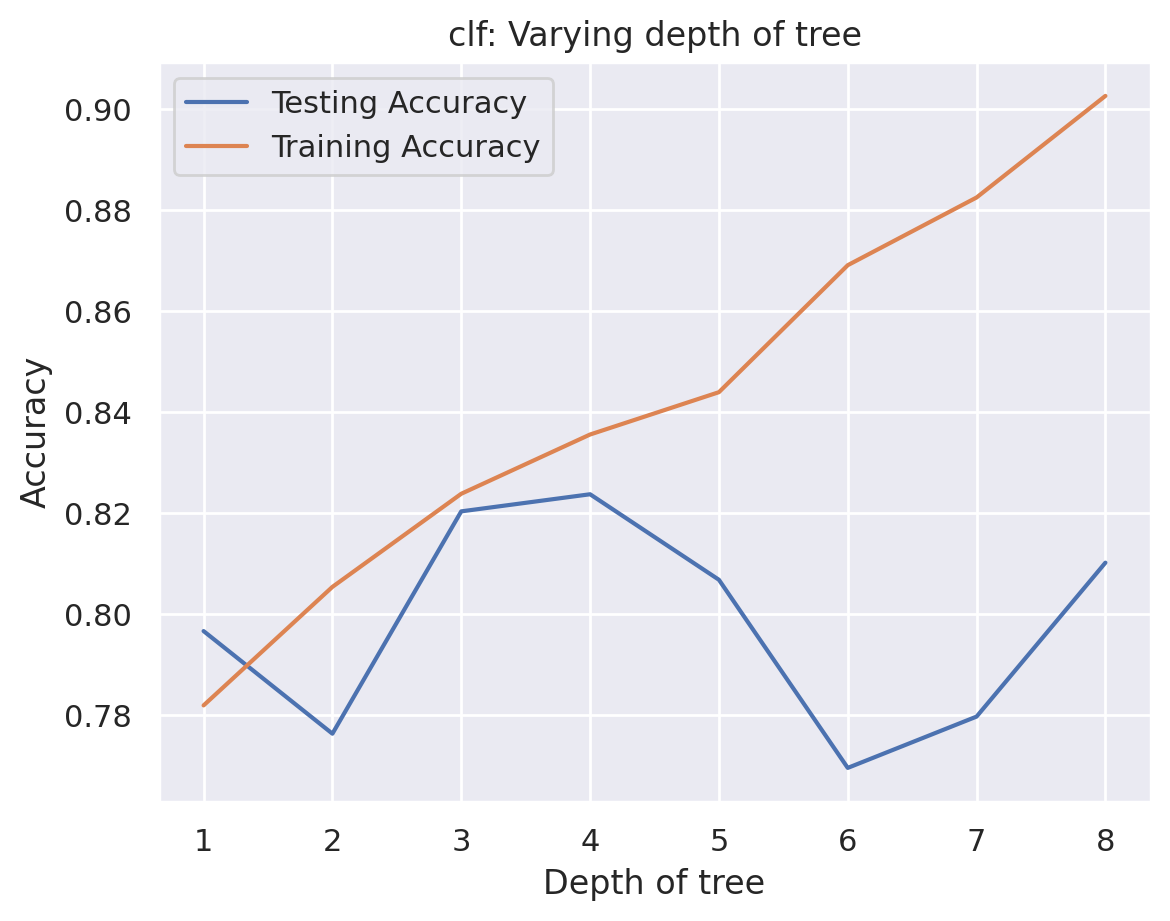

In [79]:
import numpy as np

# Setup arrays to store train and test accuracies
dep = np.arange(1, 9)
train_accuracy = np.empty(len(dep))
test_accuracy = np.empty(len(dep))

# Loop over different values of k
for i, k in enumerate(dep):
    # Setup a tree classifier with max depth k
    clf = tree.DecisionTreeClassifier(max_depth=k)

    # Fit the classifier to the training data
    clf.fit(X_train, y_train)

    #Compute accuracy on the training set
    train_accuracy[i] = clf.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = clf.score(X_test, y_test)

# Generate plot
plt.title('clf: Varying depth of tree')
plt.plot(dep, test_accuracy, label = 'Testing Accuracy')
plt.plot(dep, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Depth of tree')
plt.ylabel('Accuracy')
plt.show()

In [80]:
%%writefile titanic_flow_5.py

from metaflow import FlowSpec, step, card


class TFlow5(FlowSpec):
    """
    train a boosted tree
    """
    @card
    @step
    def start(self):
        """
        Load the data & train model
        """
        import pandas as pd
        csv_url = "https://raw.githubusercontent.com/ramnathv/full-stack-ml-metaflow-corise-week-2/main/data/titanic.csv"
        self.df = pd.read_csv(csv_url)
        self.next(self.data_prep)


    @step
    def data_prep(self):
        """
        prep data for tree-based model
        """
        import numpy as np
        import pandas as pd
        # Store target variable of training data in a safe place
        survived = self.df.Survived

        #
        df = self.df.drop(['Survived'], axis=1)

        # Impute missing numerical variables
        df['Age'] = df.Age.fillna(df.Age.median())
        df['Fare'] = df.Fare.fillna(df.Fare.median())

        df = pd.get_dummies(df, columns=['Sex'], drop_first=True)
        df = df[['Sex_male', 'Fare', 'Age','Pclass', 'SibSp']]

        X = df.values
        y = survived.values

        from sklearn.model_selection import train_test_split

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=0.33, random_state=42)

        self.grid_points = np.arange(1, 9)

        self.next(self.model3, foreach='grid_points')


    @step
    def model3(self):
        """
        make predictions
        """
        from sklearn import tree

        # Instantiate model and fit to data
        self.clf = tree.DecisionTreeClassifier(max_depth=self.input)
        self.clf.fit(self.X_train, self.y_train)
        self.score = self.clf.score(self.X_test, self.y_test)

        self.next(self.choose_model)

    @step
    def choose_model(self, inputs):
        """
        find 'best' model
        """
        import numpy as np

        def score(inp):
            return inp.clf,\
                   inp.score


        self.results = sorted(map(score, inputs), key=lambda x: -x[1])
        self.model = self.results[0][0]

        self.next(self.end)


    @step
    def end(self):
        """
        End of flow!
        """
        print('Scores:')
        print('\n'.join('%s %f' % res for res in self.results))
        print('Best model:')
        print(self.model)
        print("TFlow5 is all done.")


if __name__ == "__main__":
    TFlow5()

Writing titanic_flow_5.py


In [81]:
! python titanic_flow_5.py run

Metaflow 2.10.6 executing TFlow5 for user:metaflow_user
Validating your flow...
    The graph looks good!
Running pylint...
    Pylint is happy!
2023-11-03 23:10:37.061 Workflow starting (run-id 1699053037054692):
2023-11-03 23:10:37.064 [1699053037054692/start/1 (pid 4659)] Task is starting.
2023-11-03 23:10:38.740 [1699053037054692/start/1 (pid 4659)] Task finished successfully.
2023-11-03 23:10:38.742 [1699053037054692/data_prep/2 (pid 4681)] Task is starting.
2023-11-03 23:10:39.704 [1699053037054692/data_prep/2 (pid 4681)] Foreach yields 8 child steps.
2023-11-03 23:10:39.704 [1699053037054692/data_prep/2 (pid 4681)] Task finished successfully.
2023-11-03 23:10:39.707 [1699053037054692/model3/3 (pid 4693)] Task is starting.
2023-11-03 23:10:39.710 [1699053037054692/model3/4 (pid 4694)] Task is starting.
2023-11-03 23:10:39.717 [1699053037054692/model3/5 (pid 4695)] Task is starting.
2023-11-03 23:10:39.728 [1699053037054692/model3/6 (pid 4696)] Task is starting.
2023-11-03 23:10:3

In [ ]:
! python ../flows/local/titanic_flow_5.py card view start

Metaflow 2.7.21.4 executing TFlow5 for user:sandbox
Resolving card: TFlow5/37/start/181


In [ ]:
from metaflow import Flow
name = 'TFlow5'
run = Flow(name).latest_run
print(run.successful)

True


In [ ]:
run.data.results

[(DecisionTreeClassifier(max_depth=4), 0.823728813559322),
 (DecisionTreeClassifier(max_depth=3), 0.8203389830508474),
 (DecisionTreeClassifier(max_depth=8), 0.8101694915254237),
 (DecisionTreeClassifier(max_depth=5), 0.8067796610169492),
 (DecisionTreeClassifier(max_depth=1), 0.7966101694915254),
 (DecisionTreeClassifier(max_depth=7), 0.7830508474576271),
 (DecisionTreeClassifier(max_depth=2), 0.7762711864406779),
 (DecisionTreeClassifier(max_depth=6), 0.7661016949152543)]